### Import Statements

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

### Loading the Dataset
This dataset consists of 16 features represented in 920 rows collected from different medical institutions(Cleveland, Hungary, Switzerland, and the VA Long Beach).
The features are : id, age, sex, dataset, cp, trestbps, chol, fbs, restecg, thalch, exang, oldpeak, slope, ca, and thal
The target is the 'num' column.

In [2]:
uci_data = pd.read_csv('heart_disease_uci.csv')

In [3]:
uci_data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [4]:
uci_data.shape

(920, 16)

### Dropping irrelevant columns
Since the columns - 'id' and 'dataset' would not be relevant to the target, they are dropped from the dataset. 
So, the dataset has been reduced to 14 columns

In [5]:
df2 = uci_data.drop(['id', 'dataset'], axis=1)

In [6]:
df2['num'].value_counts()

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

In [7]:
df2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### Label Encoding categorical values
Label encoding is performed to obtain numerical inputs on categorical values which might be necessary for some machine learning models.
Encoding is done on the non-null values, preserving the null values for further processing.

In [8]:
categorical_columns = ['cp', 'restecg', 'slope', 'thal', 'ca']
label_encoders = {}
for column in categorical_columns:
    encoder = LabelEncoder()
    non_null_mask = df2[column].notna()
    non_null_values = df2[column][non_null_mask]
    encoded_values = encoder.fit_transform(non_null_values)
    df2[column] = pd.Series(index=df2.index, dtype=float)
    df2.loc[non_null_mask, column] = encoded_values
    label_encoders[column] = encoder

    print(f"\nEncoding for {column}:")
    print(f"Null values: {df2[column].isna().sum()}")
    for i, label in enumerate(encoder.classes_):
        print(f"{label} -> {i}")

# Print sample of encoded data
print("\nSample of encoded data:")
print(df2[categorical_columns].head())
print("\nNull value counts:")
print(df2[categorical_columns].isna().sum())


Encoding for cp:
Null values: 0
asymptomatic -> 0
atypical angina -> 1
non-anginal -> 2
typical angina -> 3

Encoding for restecg:
Null values: 2
lv hypertrophy -> 0
normal -> 1
st-t abnormality -> 2

Encoding for slope:
Null values: 309
downsloping -> 0
flat -> 1
upsloping -> 2

Encoding for thal:
Null values: 486
fixed defect -> 0
normal -> 1
reversable defect -> 2

Encoding for ca:
Null values: 611
0.0 -> 0
1.0 -> 1
2.0 -> 2
3.0 -> 3

Sample of encoded data:
    cp  restecg  slope  thal   ca
0  3.0      0.0    0.0   0.0  0.0
1  0.0      0.0    1.0   1.0  3.0
2  0.0      0.0    1.0   2.0  2.0
3  2.0      1.0    0.0   1.0  0.0
4  1.0      0.0    2.0   1.0  0.0

Null value counts:
cp           0
restecg      2
slope      309
thal       486
ca         611
dtype: int64


### Visualisations
According to the pie chart, there is a class data imbalance in the target column, with class 4 being severely underrepresented. Younger patients, with a median of around 50-55 seem to have less severe cases, while, older patients, with a median of around 60 have more severe cases. Several younger patients have higher severity levels, shown as dots below the boxes
Age shows a positive correlation with severity, while clinical indicators like ST slope and number of vessels (ca) display consistent changes, indicating the presence of some predictive patterns.

In [9]:
features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

Text(0.5, 1.0, 'Distribution of Heart Disease Classes')

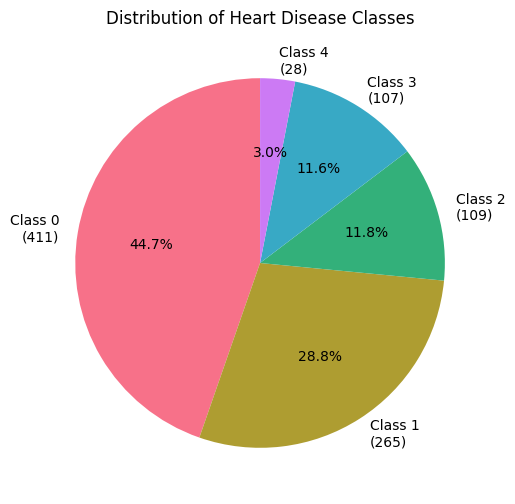

In [10]:
plt.figure(figsize=(8, 6))
target_counts = uci_data['num'].value_counts()
plt.pie(target_counts, labels=[f'Class {i}\n({count})' for i, count in enumerate(target_counts)],autopct='%1.1f%%',colors=sns.color_palette('husl', len(target_counts)),startangle=90)
plt.title('Distribution of Heart Disease Classes')

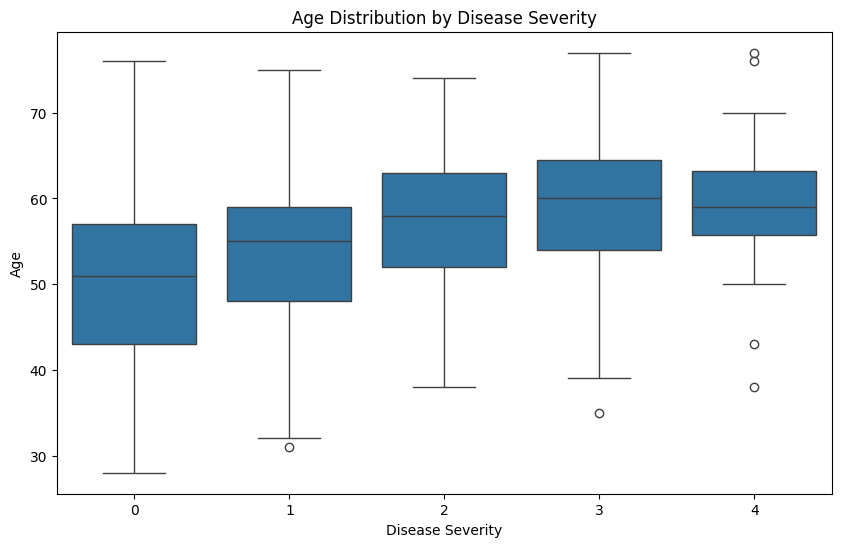

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=uci_data, x='num', y='age')
plt.title('Age Distribution by Disease Severity')
plt.xlabel('Disease Severity')
plt.ylabel('Age')
plt.show()
#Increase in age seems to cause increase in severity

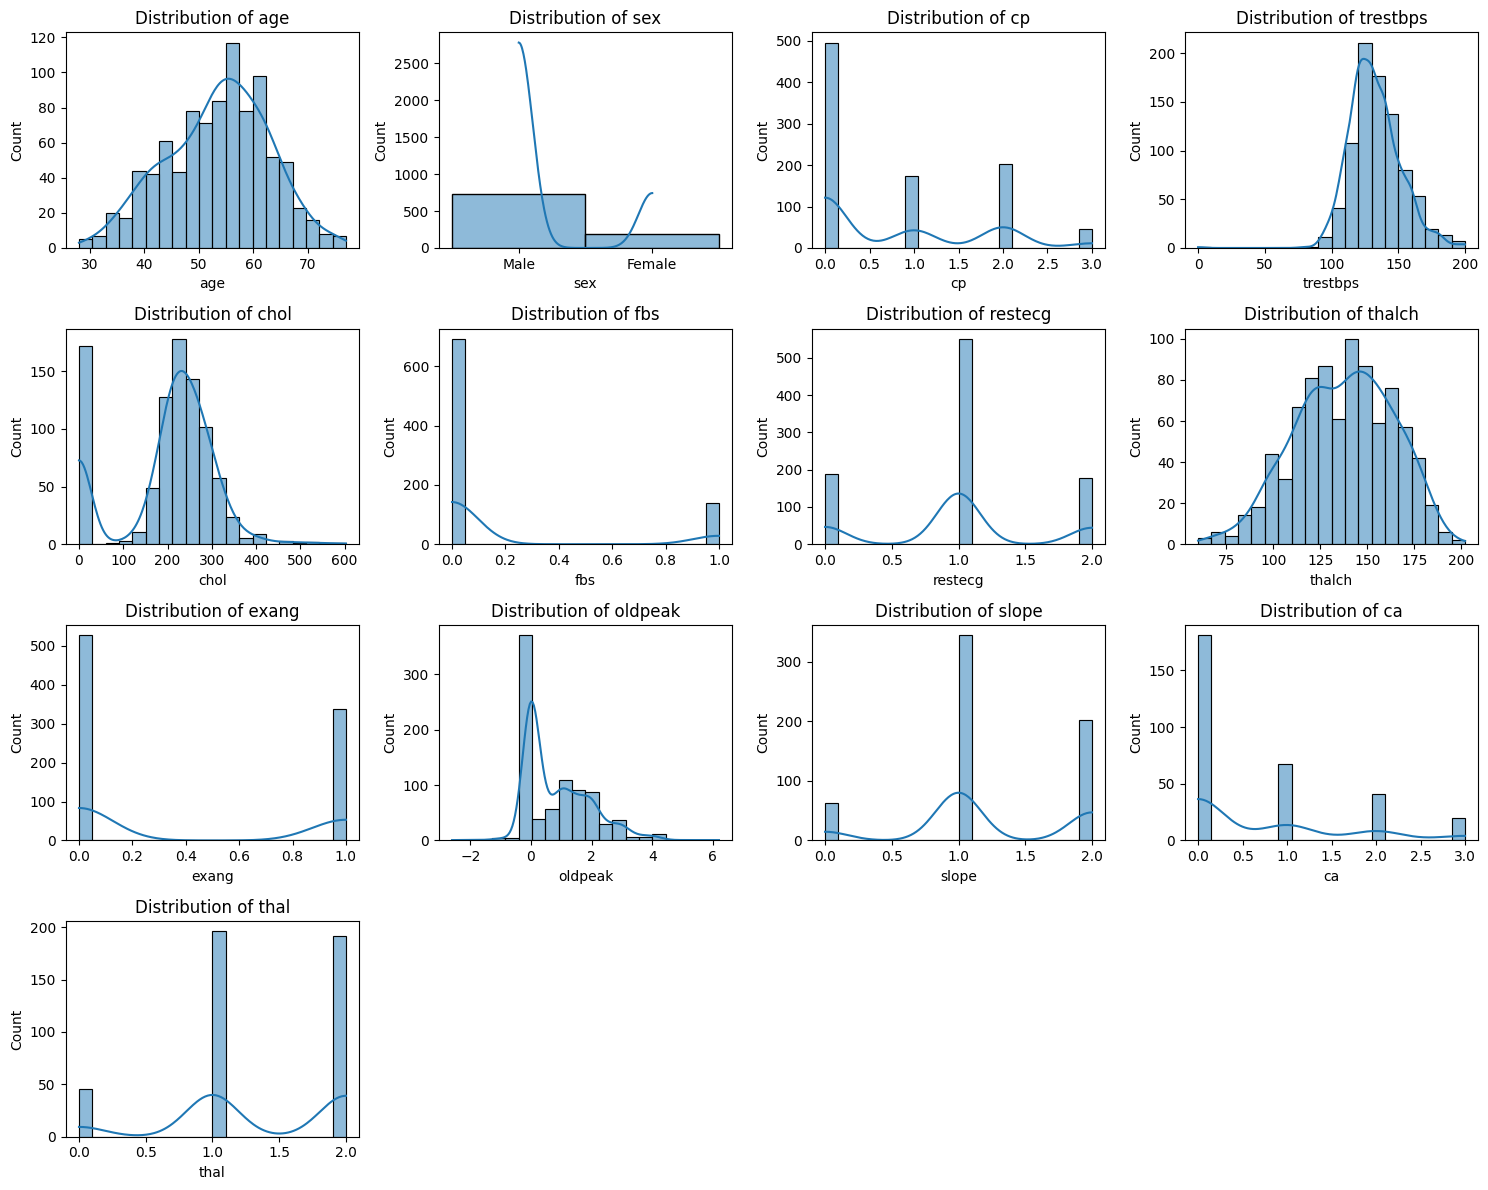

In [12]:
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features[:-1], 1):  # Excluding target 'num'
    plt.subplot(4, 4, i)
    sns.histplot(df2[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()

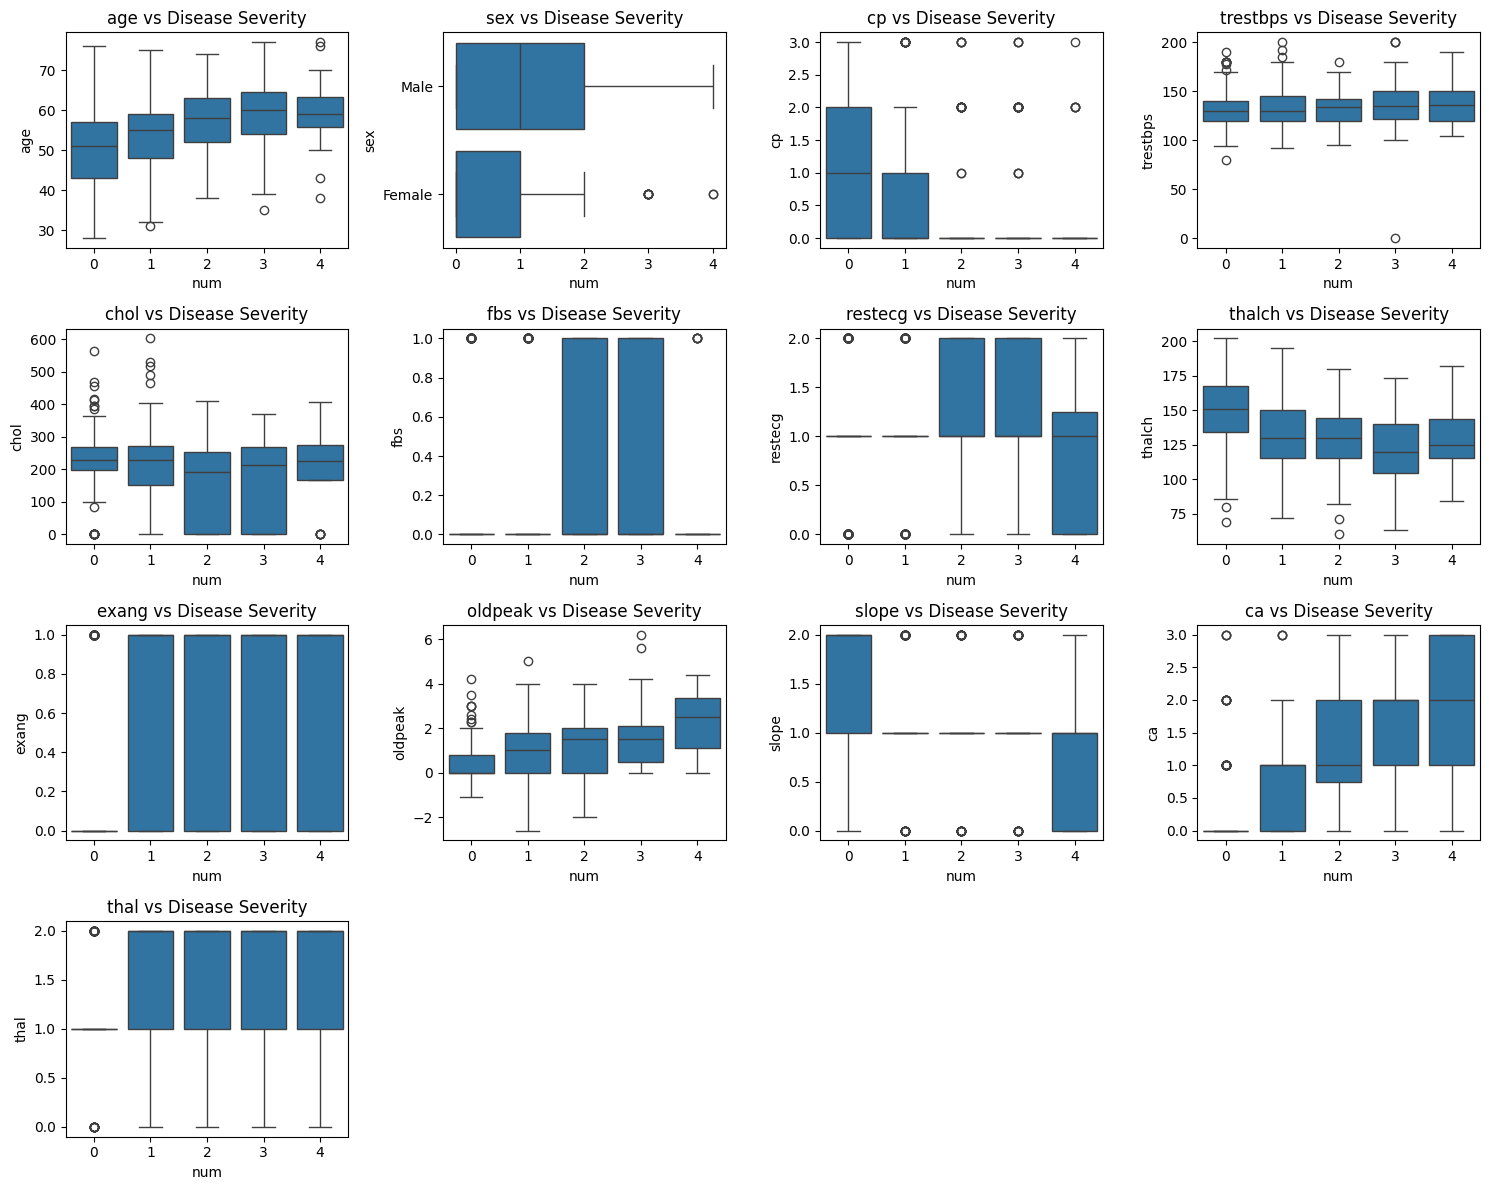

In [13]:
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features[:-1], 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x='num', y=feature, data=df2)
    plt.title(f'{feature} vs Disease Severity')
plt.tight_layout()
plt.show()

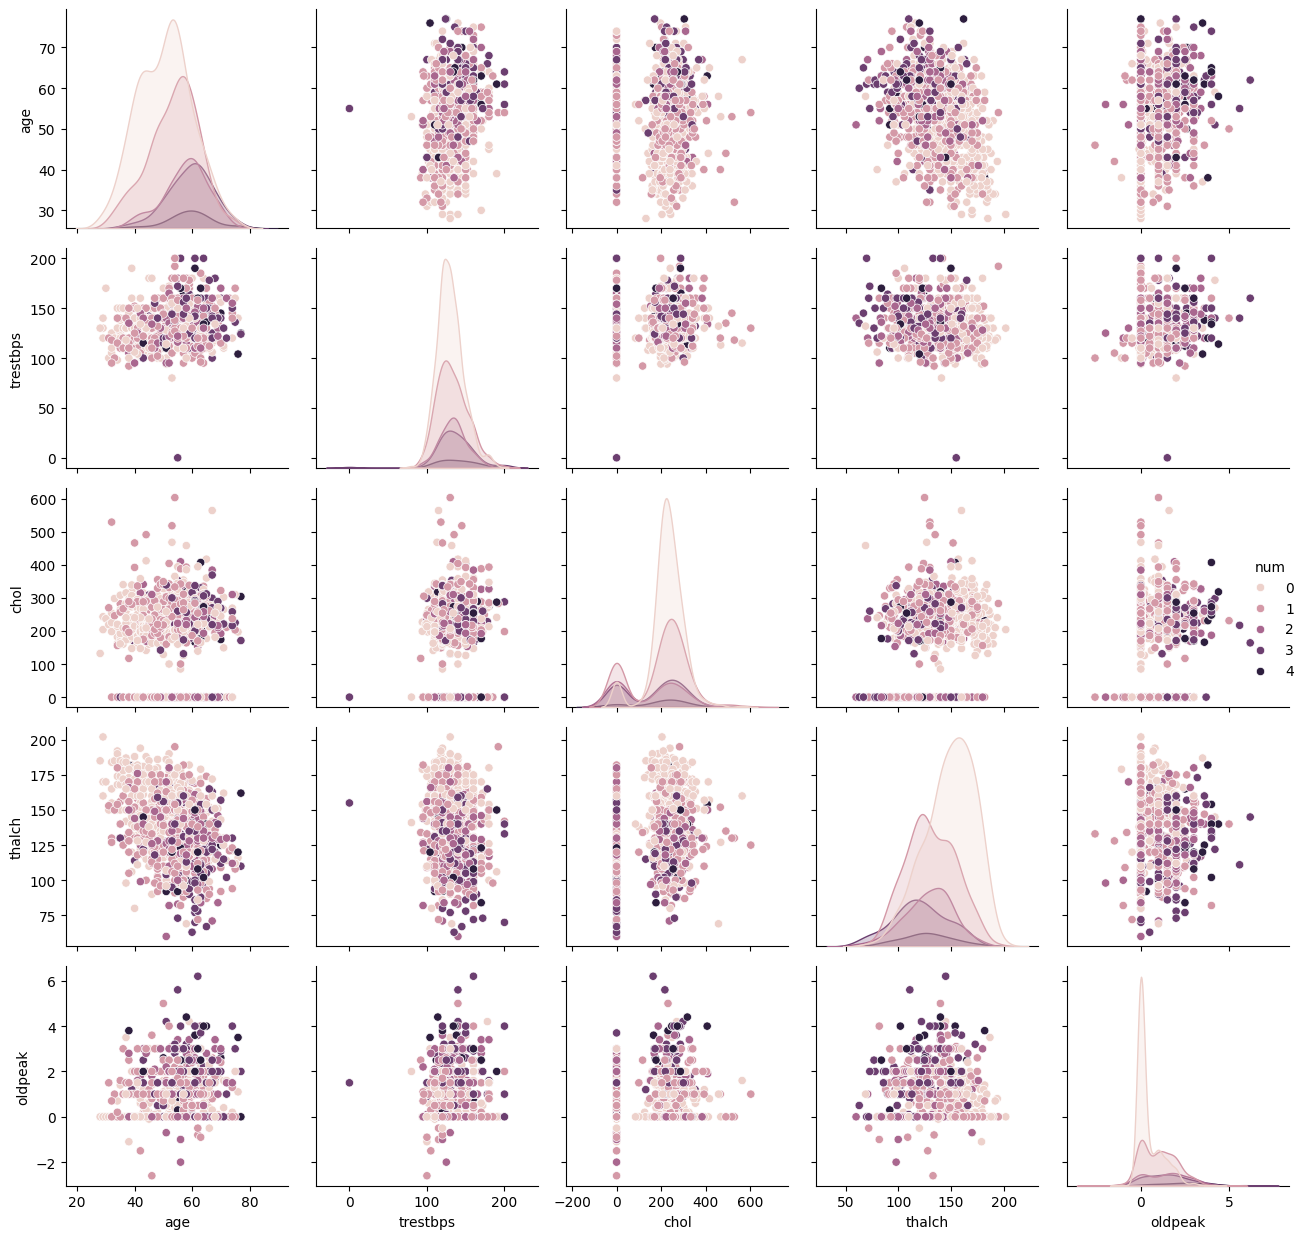

In [14]:
continuous_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'num']
sns.pairplot(df2[continuous_features], hue='num', diag_kind='kde')
plt.tight_layout()
plt.show()

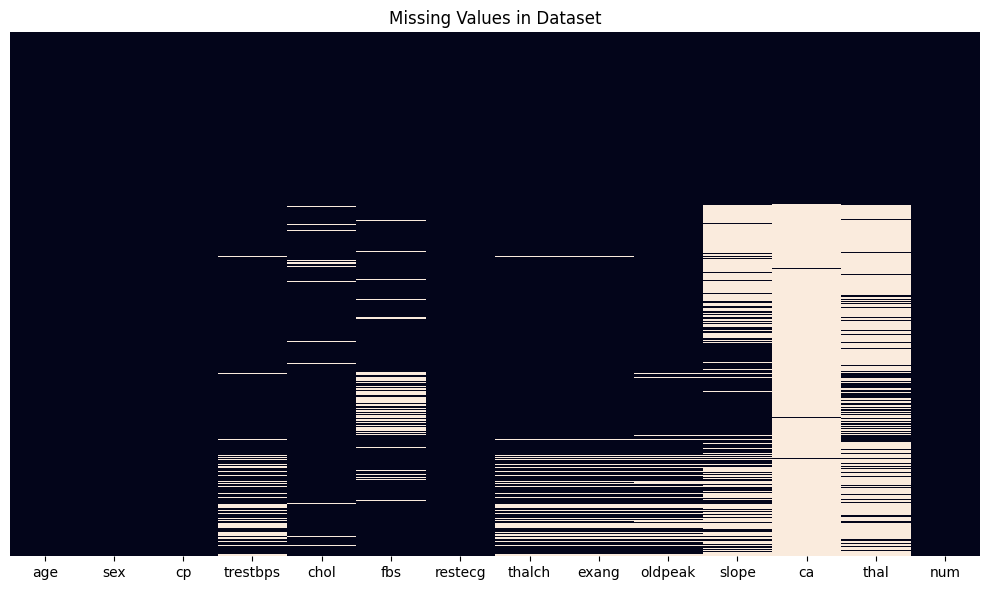

In [15]:
plt.figure(figsize=(10, 6))
sns.heatmap(df2[features].isnull(), yticklabels=False, cbar=False)
plt.title('Missing Values in Dataset')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Age vs Max Heart Rate by Disease')

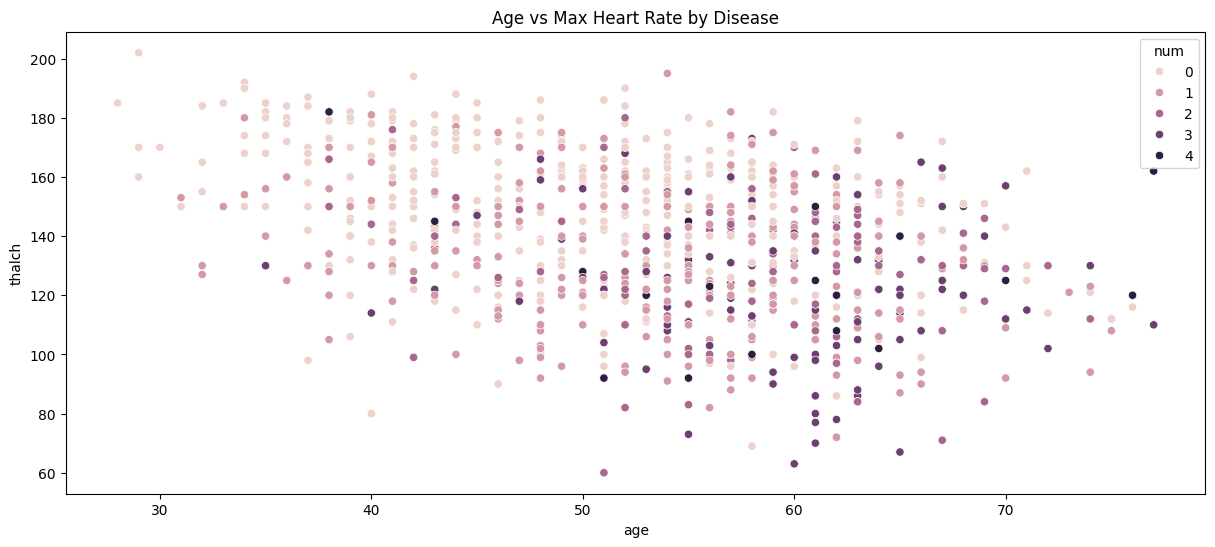

In [16]:
plt.figure(figsize=(50,6))
plt.subplot(1, 3, 1)
sns.scatterplot(data=df2, x='age', y='thalch', hue='num')
plt.title('Age vs Max Heart Rate by Disease')

Text(0.5, 1.0, 'Age vs ST Depression by Disease')

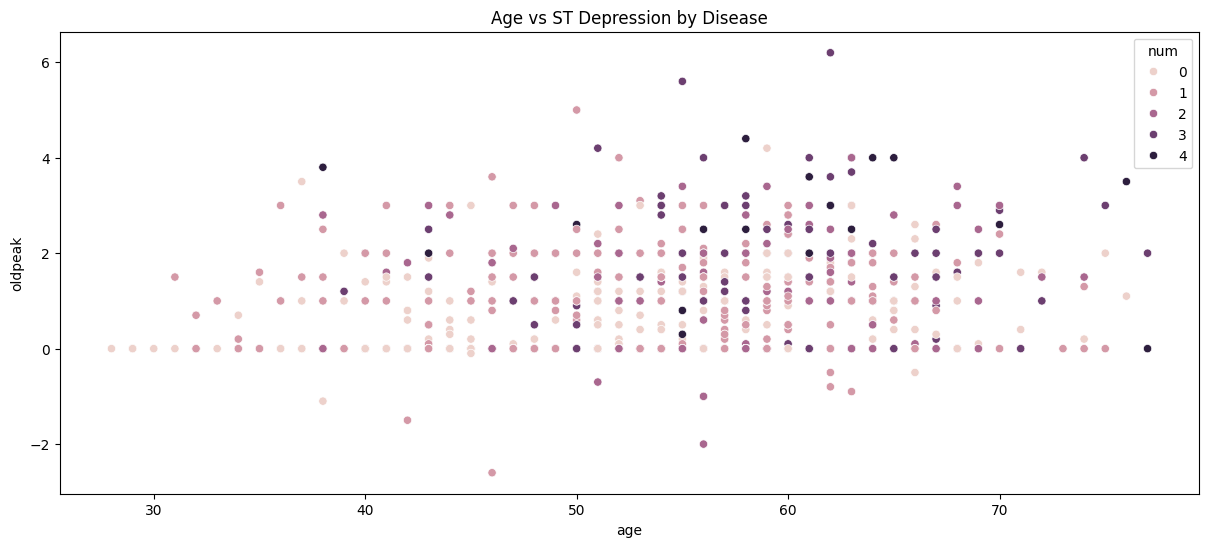

In [17]:
plt.figure(figsize=(50,6))
plt.subplot(1, 3, 2)
sns.scatterplot(data=df2, x='age', y='oldpeak', hue='num')
plt.title('Age vs ST Depression by Disease')

### Change logically flawed values to null
For cholestrol, many values appear to be zero, whuch is medically impossible. To fix this, the zero values of cholestrol are converted to null.

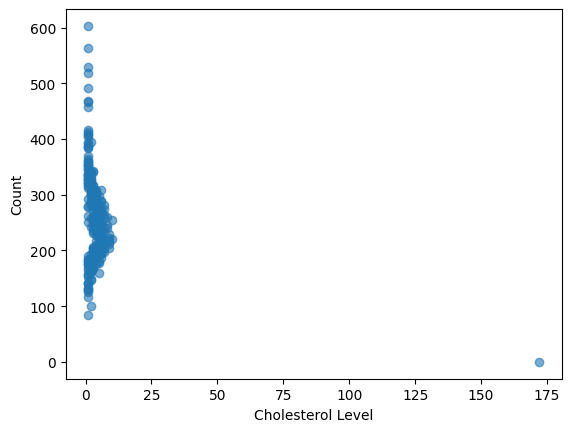

In [18]:
chol_counts = df2['chol'].value_counts().sort_index()
plt.scatter(chol_counts.values, chol_counts.index, alpha=0.6)
plt.xlabel('Cholesterol Level')
plt.ylabel('Count')
plt.show()

In [19]:
null_percentage = (df2['chol'].isnull().sum() / len(df2)) * 100
print(f"Percentage of null values in cholesterol: {null_percentage:.2f}%")

Percentage of null values in cholesterol: 3.26%


In [20]:
zero_percentage = (df2['chol'] == 0).sum() / len(df2) * 100
print(f"Percentage of zero values in cholesterol: {zero_percentage:.2f}%")

Percentage of zero values in cholesterol: 18.70%


In [21]:
print("\nBefore converting zeros to NaN:")
print(df2['chol'].describe())


Before converting zeros to NaN:
count    890.000000
mean     199.130337
std      110.780810
min        0.000000
25%      175.000000
50%      223.000000
75%      268.000000
max      603.000000
Name: chol, dtype: float64


In [22]:
df2['chol'] = df2['chol'].replace(0, np.nan)
print("\nAfter converting zeros to NaN:")
print(df2['chol'].describe())

final_null_percentage = (df2['chol'].isnull().sum() / len(df2)) * 100
print(f"\nFinal percentage of missing values: {final_null_percentage:.2f}%")


After converting zeros to NaN:
count    718.000000
mean     246.832869
std       58.527062
min       85.000000
25%      210.000000
50%      239.500000
75%      276.750000
max      603.000000
Name: chol, dtype: float64

Final percentage of missing values: 21.96%


### Analysing correlations
Positive correlations with the target indicate that the target increases as the value of the input increases. On the contrary, negative correlations indicate that the target decreases as values decrease.
Strong positive correlations can be seen with ca, oldpeak, age, exang.
Strong negative correlations can be seen with thalach, cp and slope.
This suggests that ca(Number of Vessels) is the strongest predictor of the target, while cp(chestpain) has an inverse relationship, indicating a lower risk for certain types. Basic measurements like cholestrol, restecg, show weak correlation.  
Since thalach (maximum heart rate) is negatively correlated with age, it suggests that the maximum heart rate generally declines with age.

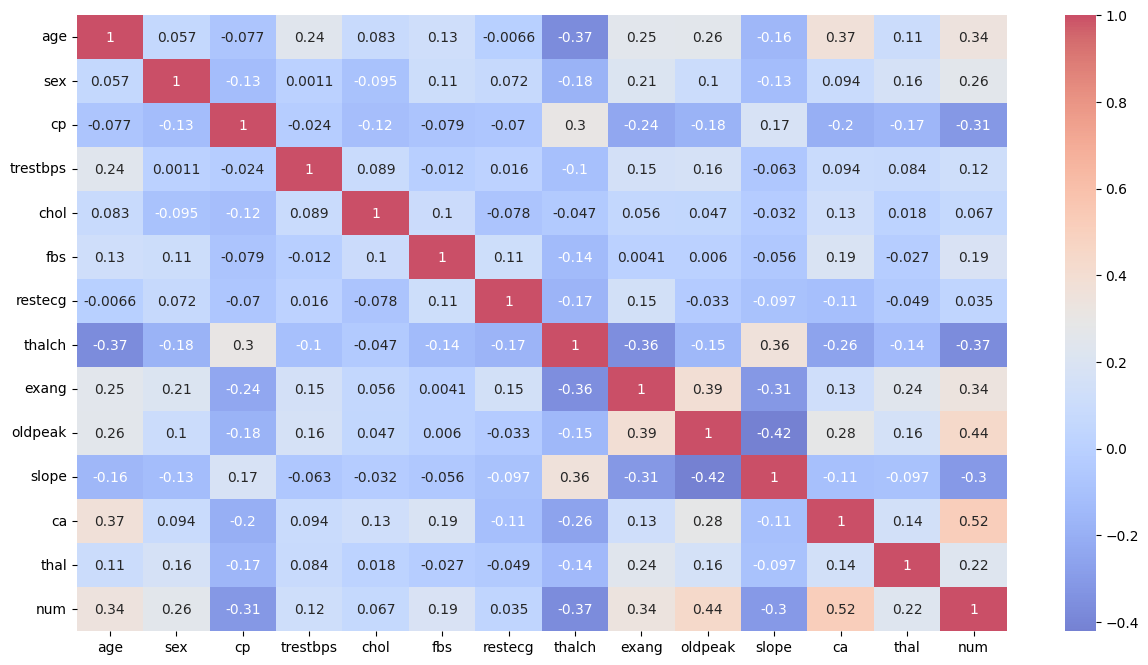

In [23]:
sns.set_palette("coolwarm")
categorical_vals = df2.select_dtypes(include=['object', 'category']).columns
for col in categorical_vals:
    df2[col] = LabelEncoder().fit_transform(df2[col])


correlation_matrix = df2.corr()
corr_features = correlation_matrix.index 
plt.figure(figsize=(15, 8))
sns.heatmap(df2[corr_features].corr(), annot=True, cmap='coolwarm', alpha=0.7, square=False)
plt.show()

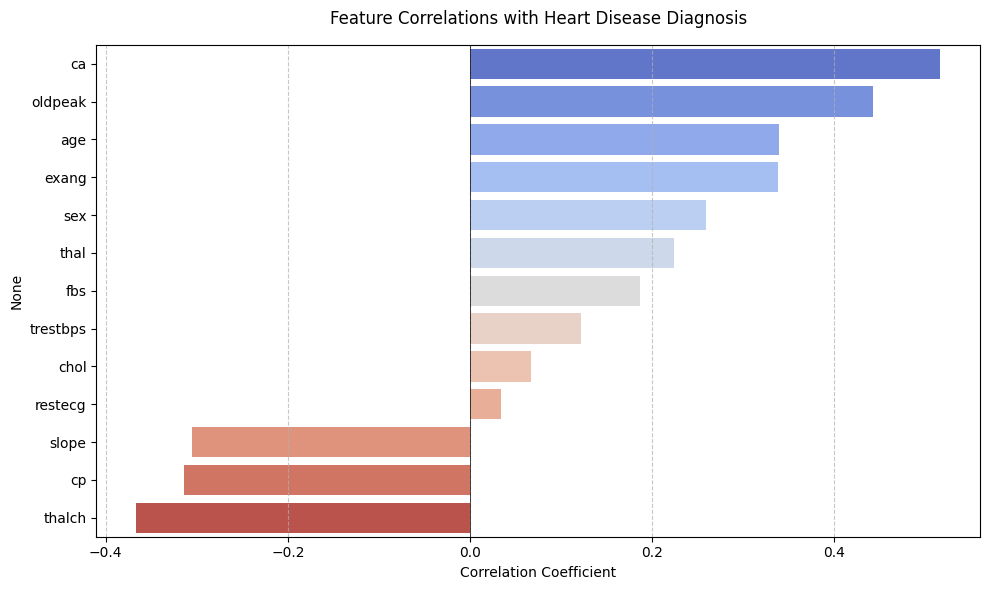


Correlations with num:
ca: 0.516
oldpeak: 0.443
age: 0.340
exang: 0.338
sex: 0.259
thal: 0.224
fbs: 0.187
trestbps: 0.122
chol: 0.067
restecg: 0.035
slope: -0.305
cp: -0.315
thalch: -0.366


In [24]:
correlations_with_num = df2.corr()['num'].sort_values(ascending=False)
correlations_with_num = correlations_with_num.drop('num')
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_with_num.values, 
            y=correlations_with_num.index,
            palette='coolwarm', hue=correlations_with_num.index, legend=False)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.title('Feature Correlations with Heart Disease Diagnosis', pad=15)
plt.xlabel('Correlation Coefficient')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()
print("\nCorrelations with num:")
for feature, correlation in correlations_with_num.items():
    print(f"{feature}: {correlation:.3f}")

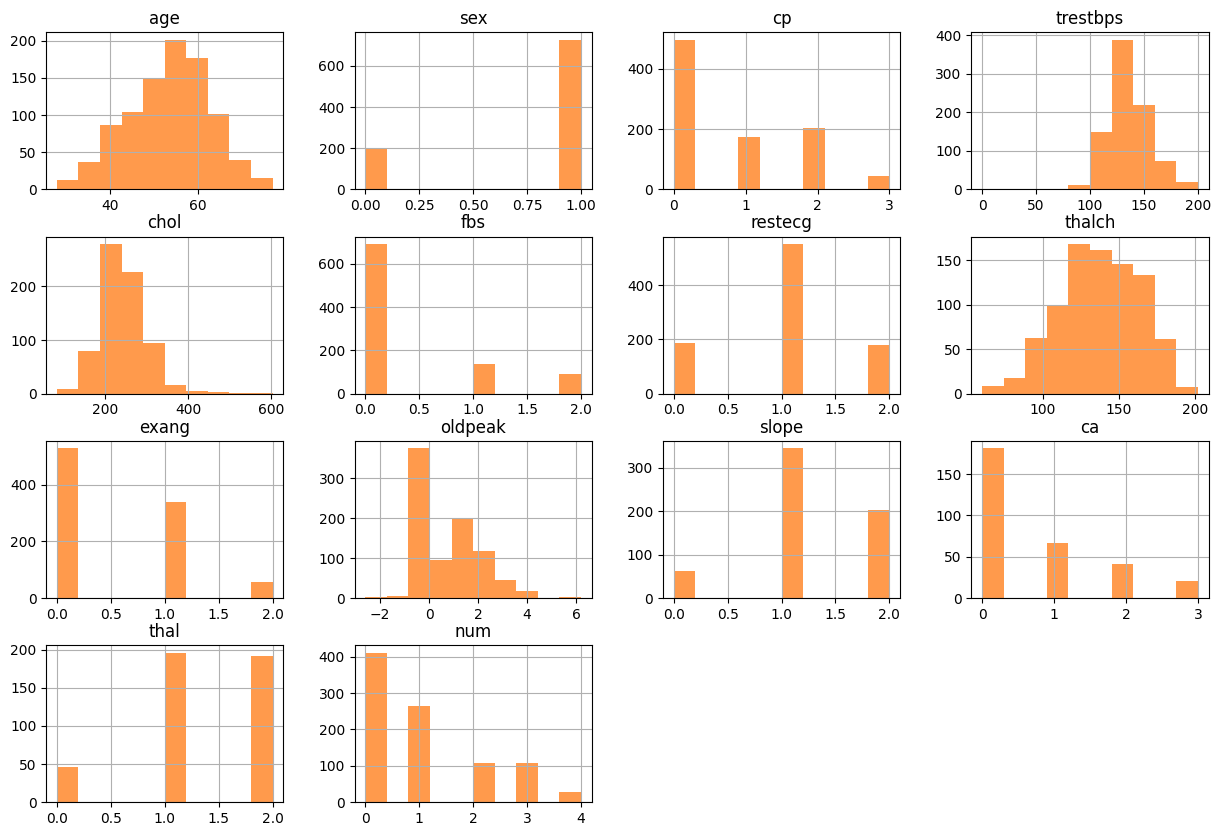

In [25]:
df2.hist(figsize=(15, 10), color='#FF6F00', alpha=0.7)
plt.show()

### Exploring Correlations
Statistics for two key features are analysed: ca and cp  
ca:
Most patients (181) have 0 vessels affected
Decreasing patient counts as vessel count increases
Higher vessel counts (2-3) show greater disease severity
The ca values positively correlate with the target.

cp:
Type 0 is the most common type (496 patients).
Types 1 and 2 have moderate frequency
Type 3 is least common (46 patients)
The cp values don't seem to follow a particular pattern, and have a varying relationship with severity.

In [26]:
df2.groupby('ca')['num'].describe()

,count,mean,std,min,25%,50%,75%,max
ca,,,,,,,,
0.0,181.0,0.453039,0.903237,0.0,0.0,0.0,1.00,4.0
1.0,67.0,1.298507,1.180844,0.0,0.0,1.0,2.00,4.0
2.0,41.0,1.902439,1.241066,0.0,1.0,2.0,3.00,4.0
3.0,20.0,2.300000,1.417930,0.0,1.0,2.5,3.25,4.0


In [27]:
df2.groupby('cp')['num'].describe()

,count,mean,std,min,25%,50%,75%,max
cp,,,,,,,,
0.0,496.0,1.443548,1.132102,0.0,1.0,1.0,2.0,4.0
1.0,174.0,0.183908,0.527372,0.0,0.0,0.0,0.0,3.0
2.0,204.0,0.661765,1.063644,0.0,0.0,0.0,1.0,4.0
3.0,46.0,0.717391,1.025520,0.0,0.0,0.0,1.0,4.0


### Analysing Missing values
The missing values are identified and imputed appropriately.
Analysis shows high missing percentages in several features like ca, thal, slope, and chol values. A total of 13.87% of data is missing from the dataset.  
Imputation methods used:  
SimpleImputer with median strategy for columns with <10% of data missing.  
KNNImputer for columns with <20% of data  missing.  
This successfully preserves the original statistics of the data and fills missing values while maintaining data distribution.

In [28]:
missing_values = df2.isnull().sum()
missing_percentage = (df2.isnull().sum() / len(df2)) * 100
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage.round(2)
})
missing_info = missing_info[missing_info['Missing Values'] > 0]
print("Columns with missing values:")
if len(missing_info) > 0:
    print(missing_info)
else:
    print("No missing values found in the dataset")
total_missing = df2.isnull().sum().sum()
total_cells = np.product(df2.shape)
print(f"\nTotal missing values: {total_missing}")
print(f"Total percentage: {(total_missing/total_cells*100):.2f}% of all cells")

Columns with missing values:
          Missing Values  Percentage
trestbps              59        6.41
chol                 202       21.96
restecg                2        0.22
thalch                55        5.98
oldpeak               62        6.74
slope                309       33.59
ca                   611       66.41
thal                 486       52.83

Total missing values: 1786
Total percentage: 13.87% of all cells


In [29]:
#if missing_percentage < 10
columns_simple = ['trestbps', 'restecg', 'thalch', 'oldpeak']
#simpleImputer strategy
df2[columns_simple] = SimpleImputer(strategy='median').fit_transform(df2[columns_simple])
print("\nValues used for imputation:")
final_missing = df2[columns_simple].isnull().sum()
#check remaining missing
print("\nRemaining missing values in imputed columns:")
print(final_missing)

original_values = df2[['chol', 'slope', 'ca']].copy()
#sample of rows with missing values
missing_samples = df2[df2[['chol', 'slope', 'ca']].isnull().any(axis=1)].head()
print("Sample rows before imputation:")
print(missing_samples[['chol', 'slope', 'ca']])

# Iterative imputation for >20%
columns_complex = ['chol', 'slope', 'ca', 'thal']
imputer = IterativeImputer(max_iter=10, random_state=42)
df2[columns_complex] = imputer.fit_transform(df2[columns_complex])
print("\nSame rows after imputation:")
print(df2.loc[missing_samples.index][['chol', 'slope', 'ca']])
for col in ['chol', 'slope', 'ca']:
   print(f"\n{col} distribution:")
   print("Before:")
   print(original_values[col].describe())
   print("\nAfter:")
   print(df2[col].describe())


Values used for imputation:

Remaining missing values in imputed columns:
trestbps    0
restecg     0
thalch      0
oldpeak     0
dtype: int64
Sample rows before imputation:
      chol  slope  ca
166  223.0    2.0 NaN
192  247.0    1.0 NaN
287  220.0    1.0 NaN
302  175.0    2.0 NaN
303  132.0    NaN NaN

Same rows after imputation:
      chol     slope        ca
166  223.0  2.000000  0.527788
192  247.0  1.000000  0.791370
287  220.0  1.000000  0.728104
302  175.0  2.000000  0.415315
303  132.0  1.287993  0.412773

chol distribution:
Before:
count    718.000000
mean     246.832869
std       58.527062
min       85.000000
25%      210.000000
50%      239.500000
75%      276.750000
max      603.000000
Name: chol, dtype: float64

After:
count    920.000000
mean     247.053314
std       51.739372
min       85.000000
25%      217.750000
50%      246.628443
75%      267.000000
max      603.000000
Name: chol, dtype: float64

slope distribution:
Before:
count    611.000000
mean       1.229133

In [30]:
df2.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

### Applying Classification Models Pre-Binning

In [31]:
# Split features and target
X = df2.drop('num', axis=1)
y = df2['num']

y = (y > 0).astype(int)

# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [32]:
models = {
    'Decision Tree': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', DecisionTreeClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=1, random_state=42))
    ]),
    'Naive Bayes': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', GaussianNB())
    ]),
    'Logistic Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=2000, random_state=42))
    ]),
    'Perceptron': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler()),  ('classifier', Perceptron(eta0=0.1, 
                                                                                                              max_iter=1000,
                                                                                                              early_stopping=True,
                                                                                                              validation_fraction=0.1,
                                                                                                              n_iter_no_change=5,
                                                                                                              class_weight='balanced',  # Handle class imbalance
                                                                                                              random_state=42
                                                                                                             ))
    ]),
    'KNN': Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=9, weights='uniform',p=1))
    ]),
    'MLP': Pipeline([
   ('imputer', SimpleImputer(strategy='mean')),
   ('scaler', StandardScaler()),
   ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, activation='relu', max_iter=5000, learning_rate_init=0.0001, validation_fraction=0.2, early_stopping=True))
])
}

In [33]:
# Training
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Predicted output
    y_pred = model.predict(X_test)
    
    # Accuracy and cross validation scores
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5)
    
    # Results
    results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'report': classification_report(y_test, y_pred),
        'predictions': y_pred
    }
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Cross-validation: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print("\nClassification Report:")
    print(results[name]['report'])
    
predictions_df = pd.DataFrame({
   'Actual': y_test
    })
for name in models.keys():
    predictions_df[name] = results[name]['predictions']

print(predictions_df)

# Parameter grids for grid search cross validation
param_grids = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [3, 5, 7, 9],
            'min_samples_split': [2, 3, 4],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'p': [1, 2],
            'leaf_size': [20, 30, 40]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=5000),
        'params': {
            'C': [0.001, 0.01, 0.1, 1.0],
            'penalty': ['l2'],
            'solver': ['liblinear']
        }
    },
    
    'MLP': {
        'model': MLPClassifier(random_state=42, max_iter=2000),
        'params': {'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
                   'learning_rate': ['constant', 'adaptive'],
                   'alpha': [0.0001, 0.001, 0.01],
                   'activation': ['relu', 'tanh']
                  }
    }
}
#Update best params according to GridSearchCV
best_params = {}
for name, config in param_grids.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X, y)
    
    best_params[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")


Decision Tree Results:
Accuracy: 0.765
Cross-validation: 0.708 (+/- 0.141)

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77        95
           1       0.84      0.69      0.76       109

    accuracy                           0.76       204
   macro avg       0.77      0.77      0.76       204
weighted avg       0.78      0.76      0.76       204


Naive Bayes Results:
Accuracy: 0.779
Cross-validation: 0.789 (+/- 0.199)

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.85      0.78        95
           1       0.85      0.72      0.78       109

    accuracy                           0.78       204
   macro avg       0.79      0.78      0.78       204
weighted avg       0.79      0.78      0.78       204


Logistic Regression Results:
Accuracy: 0.779
Cross-validation: 0.775 (+/- 0.173)

Classification Report:
              precision    recall  f1-scor

In [34]:
model_results = {
   'Model': [],
   'Accuracy': [],
   'CV Mean': [],
   'CV Std': []
}

for name, result in results.items():
   model_results['Model'].append(name)
   model_results['Accuracy'].append(result['accuracy'])
   model_results['CV Mean'].append(result['cv_mean'])
   model_results['CV Std'].append(result['cv_std'])

# Convert to DataFrame
df_results = pd.DataFrame(model_results)
df_results = df_results.sort_values('Accuracy', ascending=False)
df_results = df_results.round(3)
print(df_results.to_string(index=False))

              Model  Accuracy  CV Mean  CV Std
                KNN     0.819    0.798   0.079
        Naive Bayes     0.779    0.789   0.099
Logistic Regression     0.779    0.775   0.086
      Decision Tree     0.765    0.708   0.071
                MLP     0.765    0.758   0.069
         Perceptron     0.745    0.684   0.050


### Binning
Some columns like age, trestbps and chol might be worth binning as they can all fall into categories, while other values may not benefit from binning. For example, the values of thalch are continuous heart rates, and are more informative as such. In the case of slope, ca, and thal, they already represent discrete medical measurements.
Age could be binned using quantile(frequency width) binning, while others can have fixed length bins.  
- Age bins: Young Adult, Adult, Middle Age, Elder  
- trestbps bins: Normal, Prehypertension, Stage 1, Stage 2 
- chol bins: Normal, Borderline, High

In [31]:
numeric_cols = df2.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'num']

continuous_cols = []
for col in numeric_cols:
    unique_vals = df2[col].nunique()
    print(f"{col}: {unique_vals} unique values")
    if unique_vals > 10:
        continuous_cols.append(col)

print("\nContinuous columns that might benefit from binning:", continuous_cols)

age: 50 unique values
sex: 2 unique values
cp: 4 unique values
trestbps: 61 unique values
chol: 235 unique values
fbs: 3 unique values
restecg: 3 unique values
thalch: 119 unique values
exang: 3 unique values
oldpeak: 53 unique values
slope: 167 unique values
ca: 314 unique values
thal: 259 unique values

Continuous columns that might benefit from binning: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'slope', 'ca', 'thal']


In [32]:
print("Age distribution:", df2['age'].value_counts().sort_index())
print("\nBlood Pressure distribution:", df2['trestbps'].value_counts().sort_index())
print("\nCholesterol distribution:", df2['chol'].value_counts().sort_index())

Age distribution: age
28     1
29     3
30     1
31     2
32     5
33     2
34     7
35    11
36     6
37    11
38    16
39    15
40    13
41    24
42    18
43    24
44    19
45    18
46    24
47    19
48    31
49    22
50    25
51    35
52    36
53    33
54    51
55    41
56    38
57    38
58    43
59    35
60    32
61    31
62    35
63    30
64    22
65    21
66    13
67    15
68    10
69    13
70     7
71     5
72     4
73     1
74     7
75     3
76     2
77     2
Name: count, dtype: int64

Blood Pressure distribution: trestbps
0.0       1
80.0      1
92.0      1
94.0      2
95.0      6
         ..
180.0    12
185.0     1
190.0     2
192.0     1
200.0     4
Name: count, Length: 61, dtype: int64

Cholesterol distribution: chol
85.0     1
100.0    2
117.0    1
126.0    1
129.0    1
        ..
491.0    1
518.0    1
529.0    1
564.0    1
603.0    1
Name: count, Length: 235, dtype: int64


In [33]:
original_values = df2[['age', 'trestbps', 'chol']].copy()
#checking original ranges
print("Age range:", df2['age'].min(), "-", df2['age'].max())
print("BP range:", df2['trestbps'].min(), "-", df2['trestbps'].max())
print("Cholesterol range:", df2['chol'].min(), "-", df2['chol'].max())
# Binning
df2['age'] = pd.qcut(df2['age'], q=4, labels=[0, 1, 2, 3])
df2['trestbps'] = pd.cut(df2['trestbps'], bins=[0, 120, 140, 160, float('inf')], labels=[0, 1, 2, 3], include_lowest=True)
df2['chol'] = pd.cut(df2['chol'], bins=[0, 200, 240, float('inf')], labels=[0, 1, 2])
age_map = {0: 'Young Adult', 1: 'Adult', 2: 'Middle Age', 3: 'Elder'}
bp_map = {0: 'Normal', 1: 'Prehypertension', 2: 'Stage 1', 3: 'Stage 2'}
chol_map = {0: 'Normal', 1: 'Borderline', 2: 'High'}
# Results
for col in ['age', 'trestbps', 'chol']:
    print(f"\n{col} distribution after binning:")
    print(df2[col].value_counts().sort_index())

Age range: 28 - 77
BP range: 0.0 - 200.0
Cholesterol range: 85.0 - 603.0

age distribution after binning:
age
0    239
1    233
2    227
3    221
Name: count, dtype: int64

trestbps distribution after binning:
trestbps
0    293
1    418
2    166
3     43
Name: count, dtype: int64

chol distribution after binning:
chol
0    132
1    238
2    550
Name: count, dtype: int64


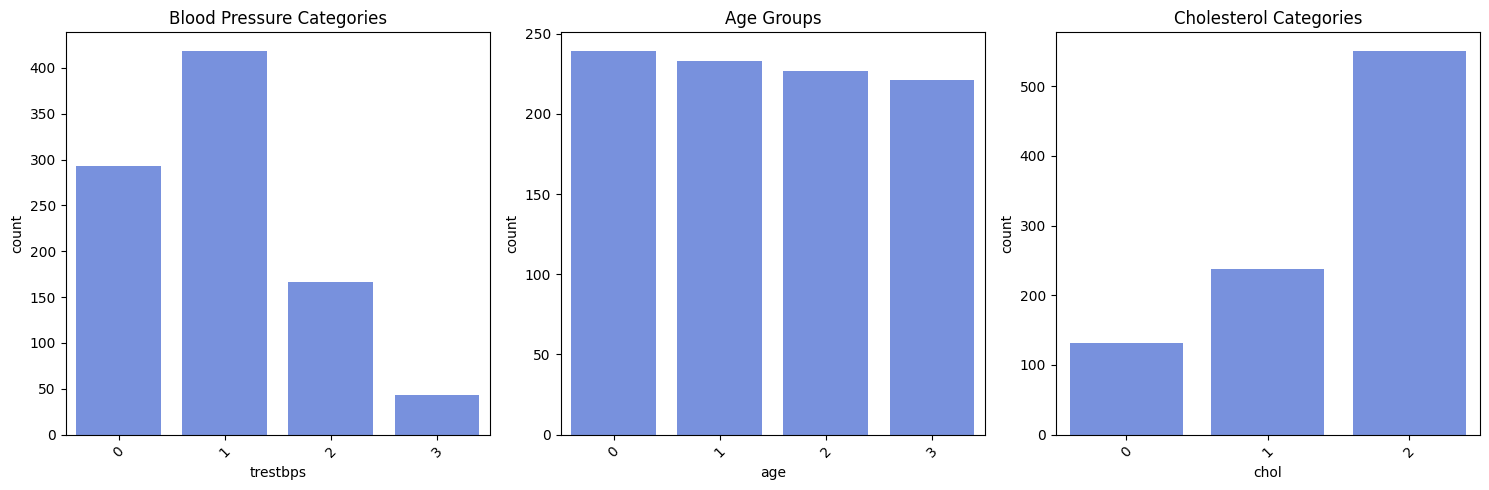

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#blood pressure
sns.countplot(data=df2, x='trestbps', ax=axes[0])
axes[0].set_title('Blood Pressure Categories')
axes[0].tick_params(axis='x', rotation=45)

#age
sns.countplot(data=df2, x='age', ax=axes[1])
axes[1].set_title('Age Groups')
axes[1].tick_params(axis='x', rotation=45)

#chol
sns.countplot(data=df2, x='chol', ax=axes[2])
axes[2].set_title('Cholesterol Categories')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Applying Classification Models Post-Binning
Some models like - Decision Tree and Naive Bayes provide better values(0.824 instead of 0.819 and 0.809 instead of 0.779) after Binning.

In [35]:
# Split features and target
X = df2.drop('num', axis=1)
y = df2['num']

y = (y > 0).astype(int)

# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [36]:
df2.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [37]:
models = {
    'Decision Tree': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', DecisionTreeClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=1, random_state=42))
    ]),
    'Naive Bayes': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', GaussianNB())
    ]),
    'Logistic Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=2000, random_state=42))
    ]),
    'Perceptron': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler()),  ('classifier', Perceptron(eta0=0.1, 
                                                                                                              max_iter=1000,
                                                                                                              early_stopping=True,
                                                                                                              validation_fraction=0.1,
                                                                                                              n_iter_no_change=5,
                                                                                                              class_weight='balanced',  # Handle class imbalance
                                                                                                              random_state=42
                                                                                                             ))
    ]),
    'KNN': Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=9, weights='uniform',p=1))
    ]),
    'MLP': Pipeline([
   ('imputer', SimpleImputer(strategy='mean')),
   ('scaler', StandardScaler()),
   ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, activation='relu', max_iter=5000, learning_rate_init=0.0001, validation_fraction=0.2, early_stopping=True))
])
}

In [38]:
# Training
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Predicted output
    y_pred = model.predict(X_test)
    
    # Accuracy and cross validation scores
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5)
    
    # Results
    results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'report': classification_report(y_test, y_pred),
        'predictions': y_pred
    }
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Cross-validation: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print("\nClassification Report:")
    print(results[name]['report'])
    
predictions_df = pd.DataFrame({
   'Actual': y_test
    })
for name in models.keys():
    predictions_df[name] = results[name]['predictions']

print(predictions_df)

# Parameter grids for grid search cross validation
param_grids = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [3, 5, 7, 9],
            'min_samples_split': [2, 3, 4],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'p': [1, 2],
            'leaf_size': [20, 30, 40]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=5000),
        'params': {
            'C': [0.001, 0.01, 0.1, 1.0],
            'penalty': ['l2'],
            'solver': ['liblinear']
        }
    },
    
    'MLP': {
        'model': MLPClassifier(random_state=42, max_iter=2000),
        'params': {'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
                   'learning_rate': ['constant', 'adaptive'],
                   'alpha': [0.0001, 0.001, 0.01],
                   'activation': ['relu', 'tanh']
                  }
    }
}
#Update best params according to GridSearchCV
best_params = {}
for name, config in param_grids.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X, y)
    
    best_params[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")


Decision Tree Results:
Accuracy: 0.824
Cross-validation: 0.761 (+/- 0.130)

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        95
           1       0.86      0.80      0.83       109

    accuracy                           0.82       204
   macro avg       0.82      0.83      0.82       204
weighted avg       0.83      0.82      0.82       204


Naive Bayes Results:
Accuracy: 0.779
Cross-validation: 0.793 (+/- 0.193)

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.83      0.78        95
           1       0.83      0.73      0.78       109

    accuracy                           0.78       204
   macro avg       0.78      0.78      0.78       204
weighted avg       0.79      0.78      0.78       204


Logistic Regression Results:
Accuracy: 0.765
Cross-validation: 0.790 (+/- 0.165)

Classification Report:
              precision    recall  f1-scor

In [39]:
model_results = {
   'Model': [],
   'Accuracy': [],
   'CV Mean': [],
   'CV Std': []
}

for name, result in results.items():
   model_results['Model'].append(name)
   model_results['Accuracy'].append(result['accuracy'])
   model_results['CV Mean'].append(result['cv_mean'])
   model_results['CV Std'].append(result['cv_std'])

# Convert to DataFrame
df_results = pd.DataFrame(model_results)
df_results = df_results.sort_values('Accuracy', ascending=False)
df_results = df_results.round(3)
print(df_results.to_string(index=False))

              Model  Accuracy  CV Mean  CV Std
      Decision Tree     0.824    0.761   0.065
                KNN     0.809    0.790   0.078
        Naive Bayes     0.779    0.793   0.097
Logistic Regression     0.765    0.790   0.083
                MLP     0.755    0.770   0.079
         Perceptron     0.696    0.688   0.059


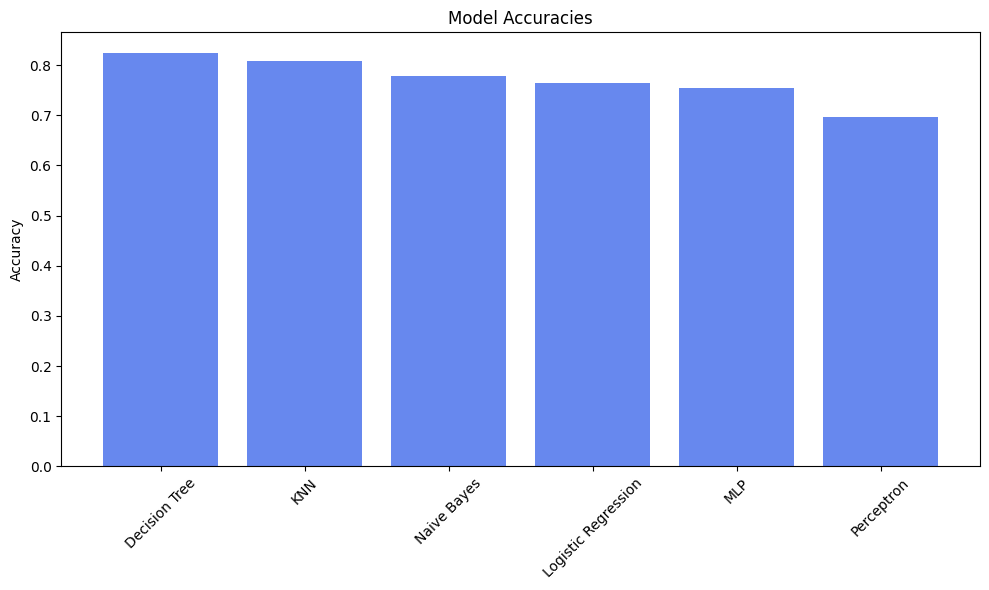

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(df_results['Model'], df_results['Accuracy'])
plt.xticks(rotation=45)
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

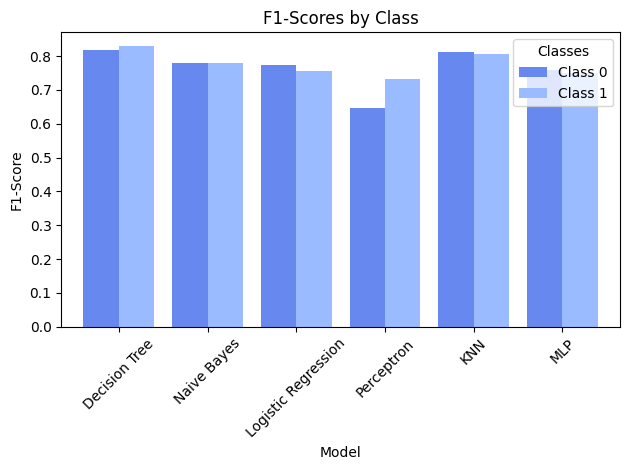

In [41]:
# Plotting F1 Scores
models = []
f1_class0 = []
f1_class1 = []

for name, result in results.items():
   report = classification_report(y_test, result['predictions'], output_dict=True)
   models.append(name)
   f1_class0.append(report['0']['f1-score'])
   f1_class1.append(report['1']['f1-score'])

data = pd.DataFrame({
   'Model': models,
   'Class 0': f1_class0,
   'Class 1': f1_class1
})

plt.figure(figsize=(10, 6))
data.plot(x='Model', y=['Class 0', 'Class 1'], kind='bar', width=0.8)
plt.title('F1-Scores by Class')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.legend(title='Classes')
plt.tight_layout()
plt.show()

In [51]:
y_pred_probs = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.7924679487179487


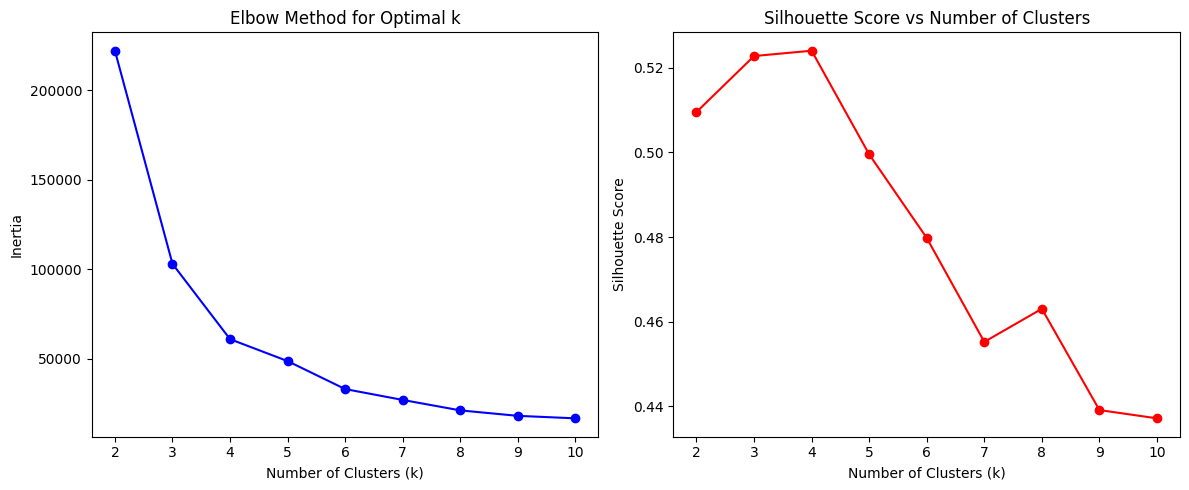

In [42]:
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')

plt.tight_layout()
plt.show()

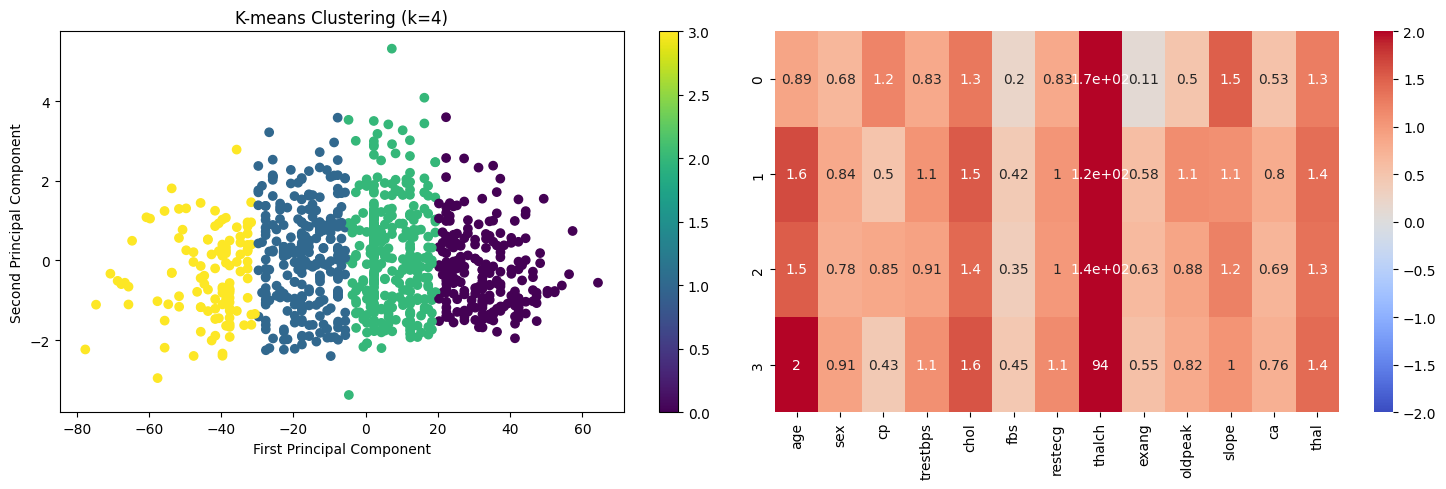

In [44]:
optimal_k = k_range[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot clusters
plt.figure(figsize=(15, 5))

# Cluster visualization
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'K-means Clustering (k={optimal_k})')
plt.colorbar(scatter)

# Heatmap
plt.subplot(1, 2, 2)
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
# Data scaling
scaled_centers = (cluster_centers - cluster_centers.mean()) / cluster_centers.std()
sns.heatmap(cluster_centers, cmap='coolwarm', center=0, vmin=-2, vmax=2, annot=True)

plt.tight_layout()
plt.show()

In [46]:
# Cluster center analysis
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

# Add a column for cluster index
cluster_centers['Cluster'] = range(optimal_k)

# Display cluster centers
cluster_centers.style.background_gradient(cmap="coolwarm", axis=1)

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,Cluster
0,0.888372,0.679070,1.200000,0.832558,1.302326,0.204651,0.832558,170.032558,0.106977,0.495814,1.512990,0.528759,1.255263,0
1,1.641221,0.835878,0.500000,1.057252,1.545802,0.416031,1.038168,120.919847,0.583969,1.123282,1.089601,0.800575,1.379747,1
2,1.527108,0.783133,0.852410,0.912651,1.436747,0.346386,1.009036,144.578313,0.632530,0.883434,1.223346,0.691779,1.348126,2
3,2.000000,0.909910,0.432432,1.081081,1.585586,0.450450,1.126126,94.045045,0.549550,0.818018,1.049579,0.763312,1.413166,3


/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_17114/3717390733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_labels, y=X[feature], palette="viridis")


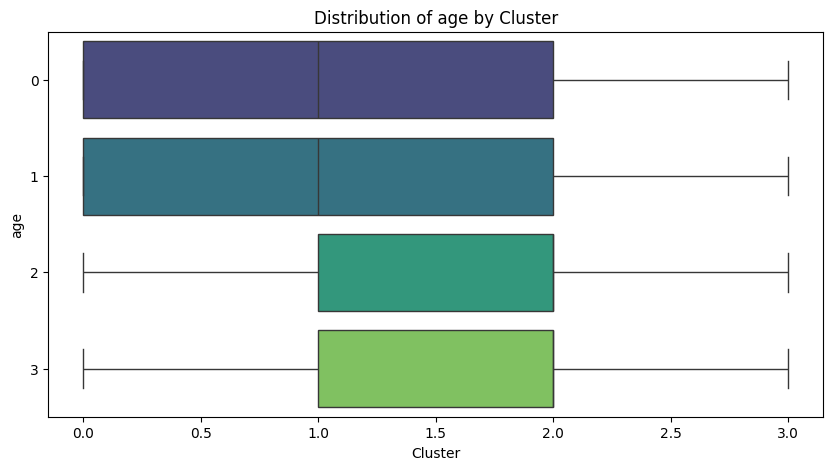

/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_17114/3717390733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_labels, y=X[feature], palette="viridis")


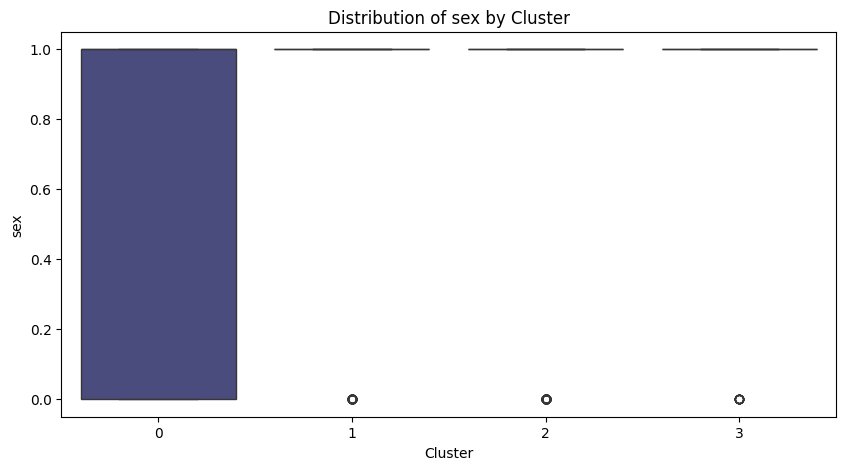

/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_17114/3717390733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_labels, y=X[feature], palette="viridis")


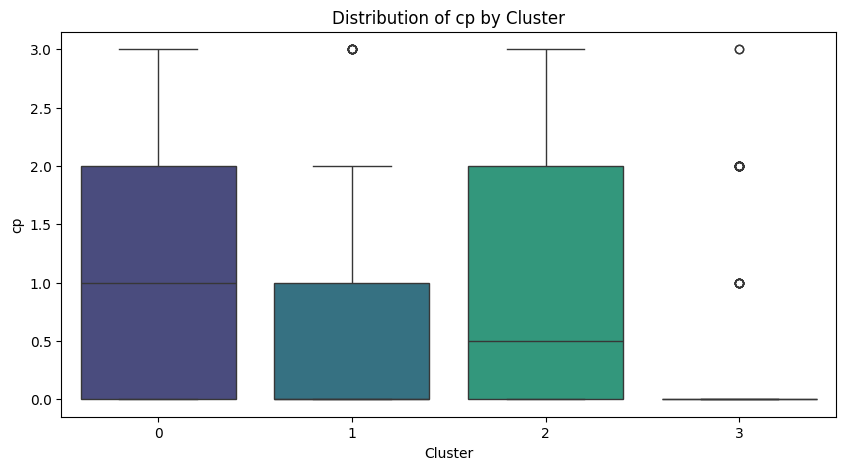

/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_17114/3717390733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_labels, y=X[feature], palette="viridis")


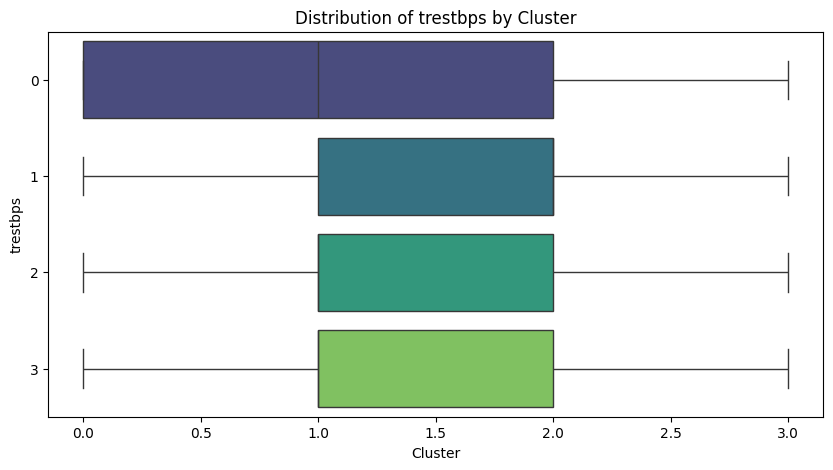

/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_17114/3717390733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_labels, y=X[feature], palette="viridis")


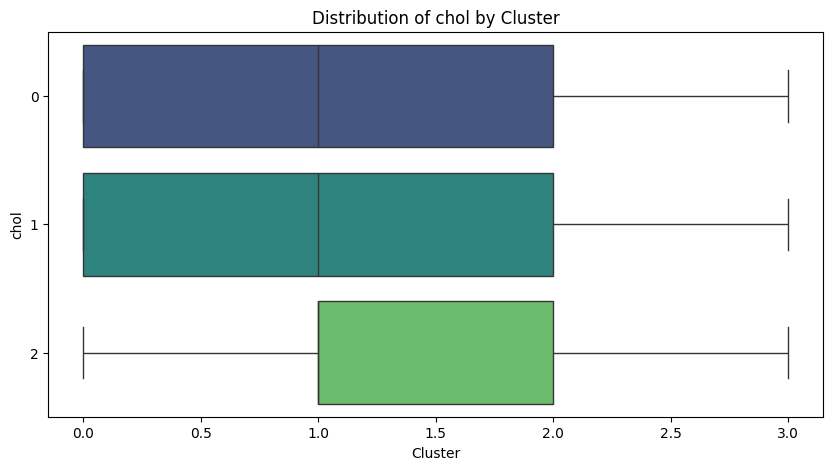

/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_17114/3717390733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_labels, y=X[feature], palette="viridis")


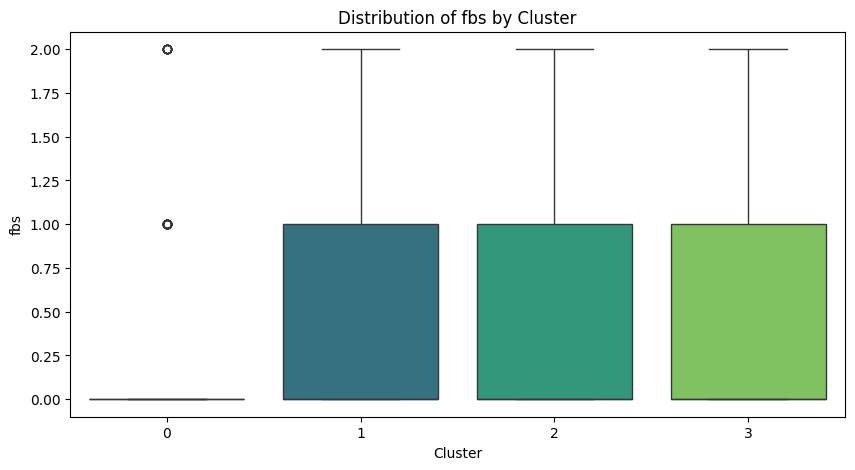

/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_17114/3717390733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_labels, y=X[feature], palette="viridis")


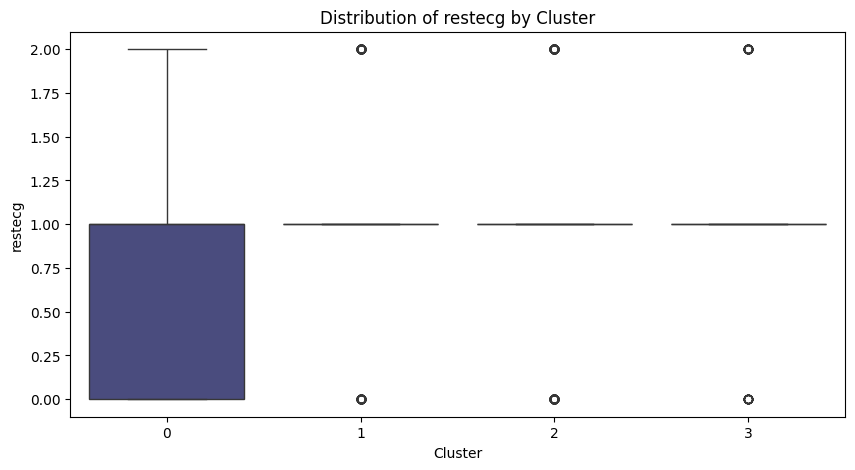

/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_17114/3717390733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_labels, y=X[feature], palette="viridis")


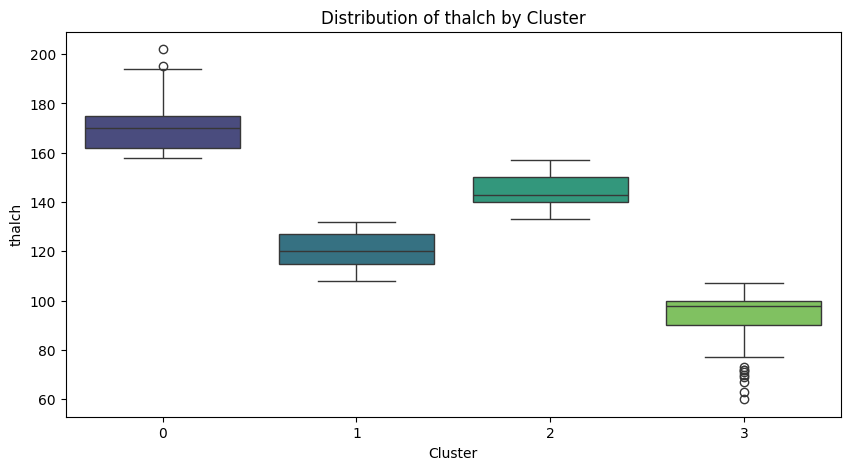

/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_17114/3717390733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_labels, y=X[feature], palette="viridis")


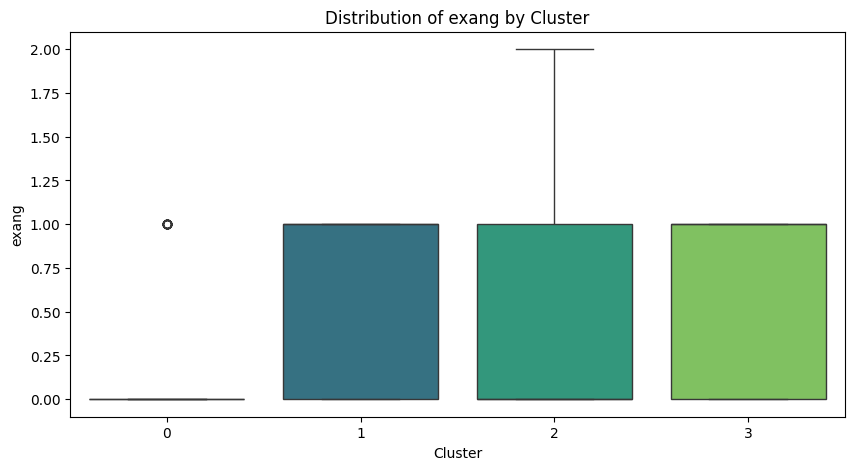

/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_17114/3717390733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_labels, y=X[feature], palette="viridis")


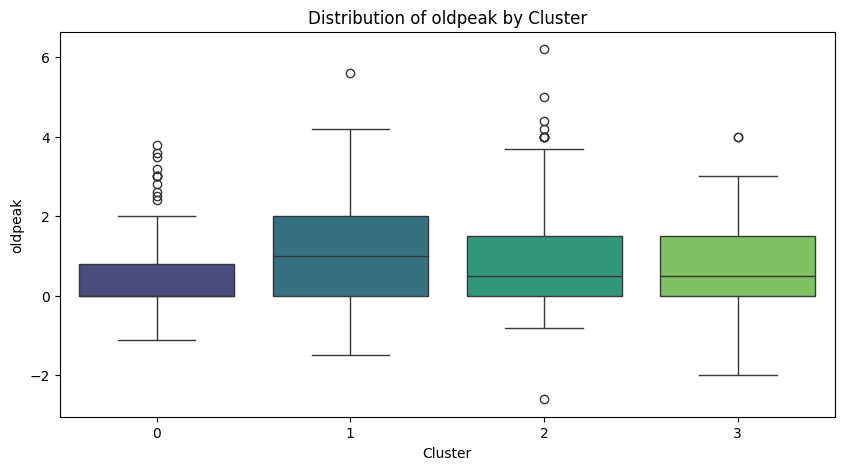

/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_17114/3717390733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_labels, y=X[feature], palette="viridis")


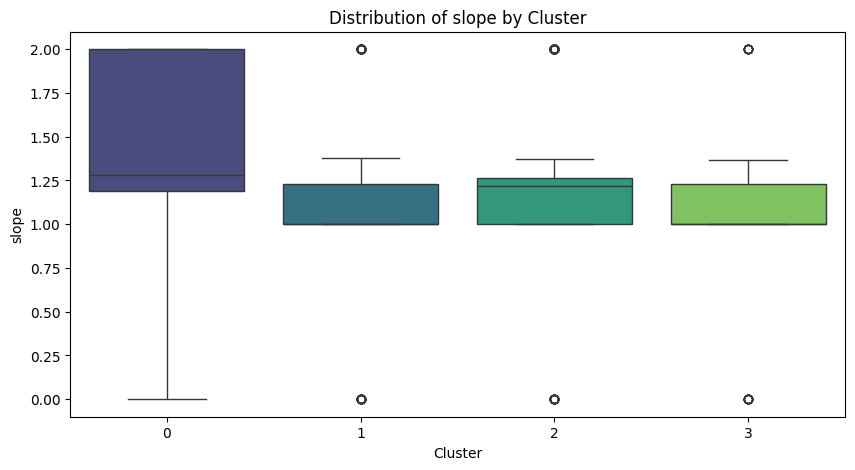

/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_17114/3717390733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_labels, y=X[feature], palette="viridis")


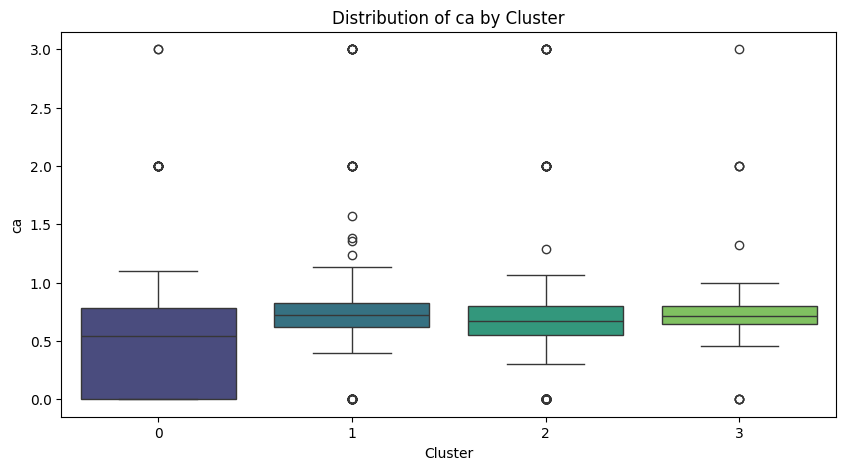

/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_17114/3717390733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_labels, y=X[feature], palette="viridis")


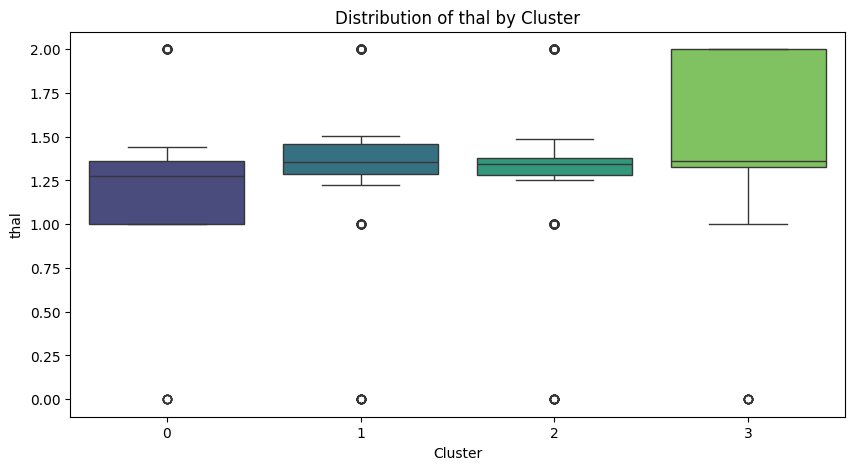

In [47]:
for feature in X.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=cluster_labels, y=X[feature], palette="viridis")
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()

### Experimental Part
According to the Cluster distributions as well as the Correlation Coefficient values obtained, it is evident that the features - 'ca', 'oldpeak' and 'thal' might be the most relevant features.  
But even on choosing just these features, the accuracy for Logistic Regression and Decision Tree classifiers do not show any improvement.  
The ROC-AUC value suggests that the model is doing a good job of seperating the two classes.

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       120
           1       0.84      0.72      0.77       156

    accuracy                           0.76       276
   macro avg       0.76      0.77      0.76       276
weighted avg       0.77      0.76      0.76       276



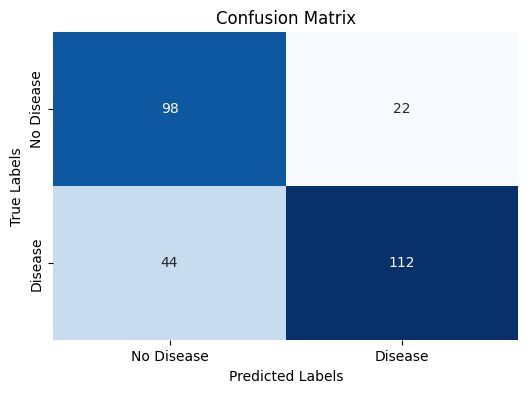

Classification Report (All Features):
              precision    recall  f1-score   support

           0       0.68      0.80      0.73       120
           1       0.82      0.71      0.76       156

    accuracy                           0.75       276
   macro avg       0.75      0.75      0.75       276
weighted avg       0.76      0.75      0.75       276



In [56]:
# Selecting most correlated features
X_selected_train = X_train[['ca', 'oldpeak', 'thal']]
X_selected_test = X_test[['ca', 'oldpeak', 'thal']]

# Train Decision Tree
model = DecisionTreeClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=1, random_state=42)
model.fit(X_selected_train, y_train)

# Predictions
y_pred = model.predict(X_selected_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion matrix visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

model = LogisticRegression(random_state=42)
model.fit(X_selected_train, y_train)

# Predictions
y_pred_full = model.predict(X_selected_test)

# Evaluate
print("Classification Report (All Features):")
print(classification_report(y_test, y_pred_full))

In [53]:
y_pred_probs = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.7913194444444445
